### Camera Calibration

In [ ]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import pickle
import re
%matplotlib inline

No of Images 20
Camera Calibration Done!


{'dist': array([[ -2.41017968e-01,  -5.30720497e-02,  -1.15810318e-03,
          -1.28318543e-04,   2.67124302e-02]]),
 'mtx': array([[  1.15396093e+03,   0.00000000e+00,   6.69705359e+02],
        [  0.00000000e+00,   1.14802495e+03,   3.85656232e+02],
        [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])}

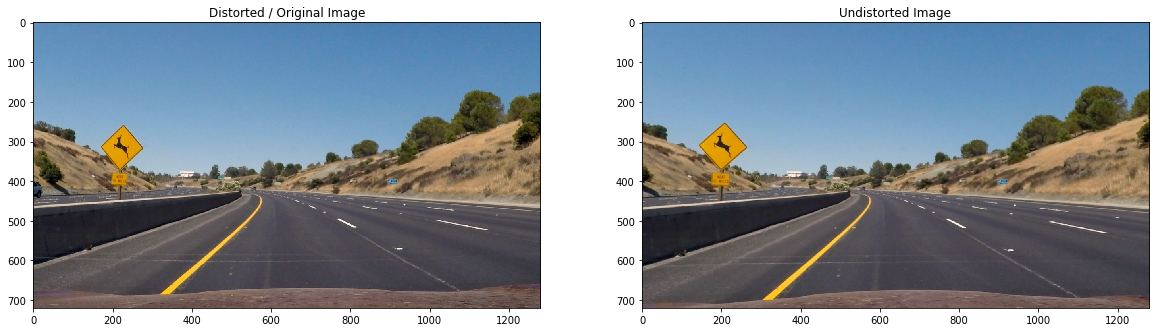

In [3]:
#Camera Calibration
def calibrate_camera():
    img_names = glob.glob('camera_cal/calibration*.jpg')
    print('No of Images {}'.format(len(img_names)))

    #Image points are the coordinates for image and Object points are coordinates for undistored 3D image
    objpoints = [] #3D with 3rd co-or always 0 since it is a plane
    imgpoints = [] #2D
    
    #Our board has x = 9 (0 - 8), y = 6 (0 - 5). If assuming corner right intersetction as (0, 0, 0), you'll have 9 * 6 intersections
    objp = np.zeros((9*6, 3), np.float32)

    """
    Generate coordinates for X, Y using mpgrid (assuming each box is 1*1 length)
    Z coordinate is 0, no need to populate it
    [:, :2] means all 9*6 values for 0th and 1st array, leaving 2nd which is for Z coordinate
    Reshape to 2 columns
    """
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)
    for img_name, i in zip(img_names, range(len(img_names))):

        #To create the image points, Look at the distorted image and use cv2(on gray scale) and detect corners
        img = cv2.imread(img_name)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(img_gray, (9, 6), None)
        #print('{}. Return value for Image {} --> {}'.format(i+1, img_name, ret))
        #If the function detects corners, then append those to image points
        if ret:
            imgpoints.append(corners)
            objpoints.append(objp) #This is printing correctly
            #draw detected corners
            #img_draw = cv2.drawChessboardCorners(img, (8, 6), corners, ret)
            
    #Saving to a pickle
    img = cv2.imread('test_images/test2.jpg')
    shape = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
    undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
    print('Camera Calibration Done!')
    #Plotting
    fig, axs = plt.subplots(1,2, figsize=(20, 10))
    axs[0].set_title('Distorted / Original Image')
    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Undistorted Image')
    axs[1].imshow(cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB))

    dist_pickle = {}
    dist_pickle['mtx'] = mtx
    dist_pickle['dist'] = dist
    pickle.dump(dist_pickle, open("data/calibration_pickle.p", 'wb'))
    
    
    return dist_pickle

calibrate_camera()


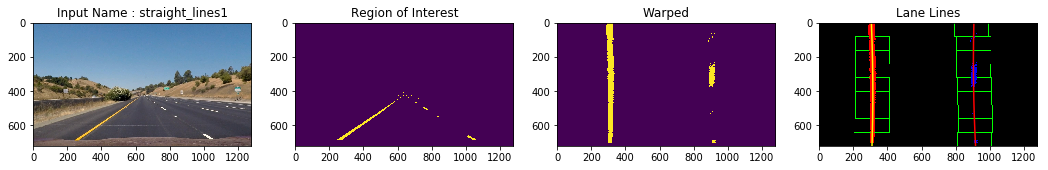

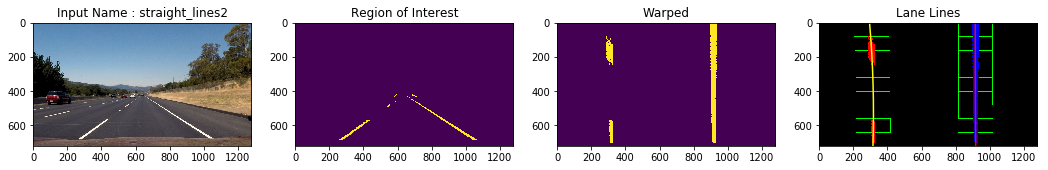

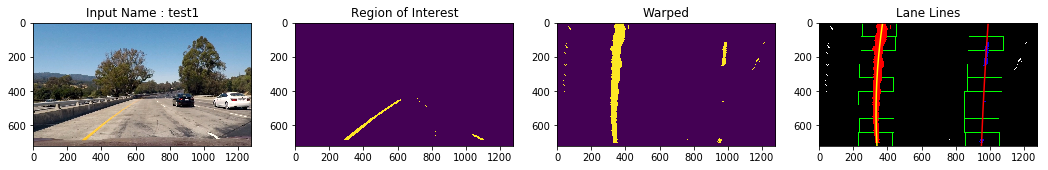

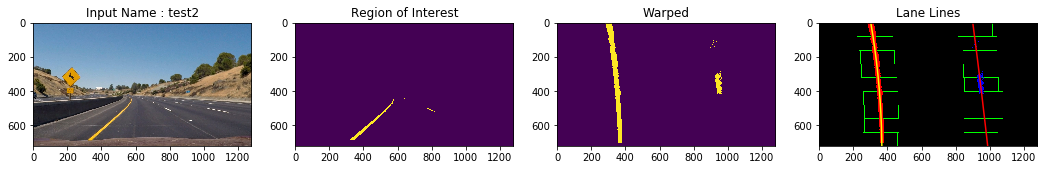

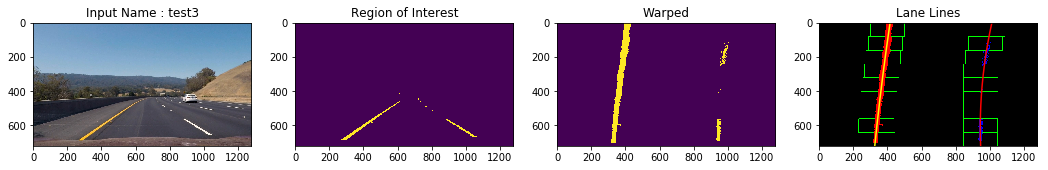

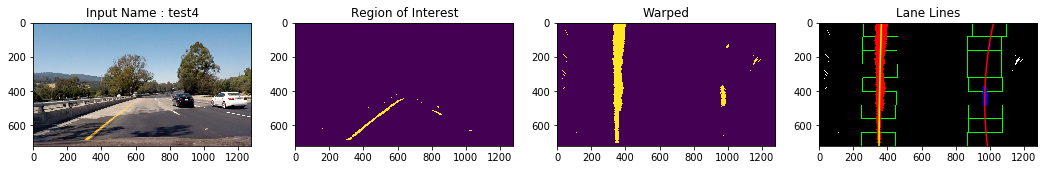

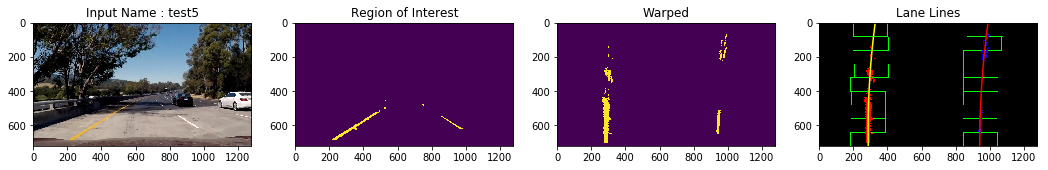

In [4]:
#Loading pickle
def load_pickle():
    dist_pickle = pickle.load( open('data/calibration_pickle.p', 'rb'))
    mtx = dist_pickle['mtx']
    dist = dist_pickle['dist']
    return mtx, dist

#Perspective Transformation
def warp_image(img, src, dst):
    #Perspective tranform, M
    M = cv2.getPerspectiveTransform(src, dst)

    #Inverse Perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)

    img_size = (img.shape[1], img.shape[0])
    #warped image - uses linear interpolation
    warped_img = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped_img, Minv

def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """
    Determine sobel for x or y
    Absolute soble
    uint8
    binary
    """
    img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        #print('inside x')
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0)
        abs_sobel = np.absolute(sobel)
    else:
        #print('inside y')
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1)
        abs_sobel = np.absolute(sobel)
        
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    img_binary = np.zeros_like(scaled_sobel)
    img_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return img_binary



def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    """
    Determine sobelx and sobely
    sqrt(x**2 + y**2)
    uint8
    binary
    """
    img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobel_mag = np.sqrt(sobelx**2 + sobely**2)

    #scaled_sobel = np.uint8(255*sobel_mag/np.max(sobel_mag))
    scale_factor = np.max(sobel_mag)*255
    scaled_sobel = (sobel_mag/scale_factor).astype(np.uint8)
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, thresh, sobel_kernel=3):
    """
    Determine sobelx and sobely
    Absolute
    arctan2(y, x)
    binary
    """
    img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    dir_sobel = np.arctan2(sobely, sobelx)
    dir_binary = np.zeros_like(dir_sobel)
    dir_binary[(dir_sobel >= thresh[0]) & (dir_sobel <= thresh[1])] = 1
    return dir_binary

def color_threshold(img, sthresh=(0, 255), vthresh=(0, 255)):
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = img_hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1
    
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = img_hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= vthresh[0]) & (v_channel <= vthresh[1])] = 1

    output = np.zeros_like(s_channel)
    output[(s_binary == 1) & (v_binary == 1)] = 1
    
    return output

######################################################################################
#Undistorting
mtx, dist = load_pickle()
test_images = glob.glob('test_images/*.jpg')
#print('No of Images read {}'.format(len(test_images)))
#img = cv2.imread('test_images/straight_lines2.jpg')
for idx, image_name in enumerate(test_images):
    img = cv2.imread(image_name)
    undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)

    #Plotting Undistorted Image
    #     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    #     ax1.set_title('Distorted / Original Image')
    #     ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    #     ax2.set_title('Undistorted Image')
    #     ax2.imshow(cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB))

    #Thresholding
    sobelx = abs_sobel_thresh(undistorted_img, 'x', 3, (30,125))
    sobely = abs_sobel_thresh(undistorted_img, 'y', 3, (70,255))
    dir_binary = dir_threshold(undistorted_img, (0.8, 1.2))
    sv_channel = color_threshold(undistorted_img, (100, 255), (90, 255))

    combined_binary = np.zeros_like(sobelx)
    combined_binary[((sobelx == 1 )  & (sobely == 1 ) & (dir_binary == 1)  | (sv_channel == 1))] = 1

    #print('Shapes Sobel {} S Channel {} Combined Binary {}'.format(sobelx.shape, sv_channel.shape, combined_binary.shape))


    #Region of Interest
    height, width = img.shape[:2]
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    #print('height {} width {} ignore maks color {}'.format(height, width, ignore_mask_color))

    vertices = np.array([[(0, 0.95*height),(0.49*width,0.56*height),
                          (0.51*width,0.56*height),(width, 0.95*height)]], dtype=np.int32)
    mask = np.zeros_like(combined_binary)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    roi_image = cv2.bitwise_and(combined_binary, mask)

    #Perspective Transformation
    src = np.float32([[220,720],
                      [1110, 720],
                      [570, 470],
                      [722, 470]])
    dst = np.float32([[320,720],
                      [920, 720],
                      [320, 1],
                      [920, 1]])
    warped_img, Minv = warp_image(roi_image, src, dst)

    #Writing image to a folder
    #     write_name_masked = image_name.split('.', 1)[0]+'_masked.jpg'
    #     write_name_warped = image_name.split('.', 1)[0]+'_warped.jpg'
    #     print(write_name_masked)
    #     cv2.imwrite(write_name_masked, roi_image)
    #     cv2.imwrite(write_name_warped, warped_img)

    #Plotting
    fig, axs = plt.subplots(1,4, figsize=(18, 18))
    axs[0].set_title('Input Name : '+re.search('test_images\\\(.*).jpg', image_name).group(1))
    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Region of Interest')
    axs[1].imshow(roi_image)
    axs[2].set_title('Warped')
    axs[2].imshow(warped_img)

    ########################################################################
    #Lane Detection Start
    #print('shape of binary warped', warped_img.shape) #(720, 1280) height * width

    histogram = np.sum(warped_img[warped_img.shape[0]//2:,:], axis=0)
    #plt.plot(histogram)
    #print('shape of binary warped', warped_img.shape)
    out_img = np.dstack((warped_img, warped_img, warped_img))*255
    #out_img = np.zeros_like(warped_img)
    #print('shape of dstack',out_img.shape)

    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    #print('Shape of Input Image {} Shape of Input Image {} midpoint {} left peak {} right peak {}'.format(warped_img.shape, histogram.shape, midpoint, leftx_base, rightx_base))

    nwindows = 9
    window_height = np.int(warped_img.shape[0] // nwindows)

    #Returns a tuple of arrays, one for each dimension of a, 
    #containing the indices of the non-zero elements in that dimension
    nonzero = warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx_current = leftx_base
    rightx_current = rightx_base
    #print('current left and right ', leftx_current, rightx_current)

    margin = 100
    minpix = 50

    left_lane_inds = []
    right_lane_inds = []

    for i in range(nwindows):
        #print('-----------------Window {} ------------------'.format(i))
        win_y_low = warped_img.shape[0] - (i+1) * window_height
        win_y_high = warped_img.shape[0] - i * window_height #This is the lower dimension
        
        #Left lane box
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        #Right lane box
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        #Drawing
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
        #print('rectangles drawn')
        #non-zero pixels in x & y
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        #print('Length of good left {} good right {} '.format(len(good_left_inds), len(good_right_inds)))

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    #     print('Appending to left_lane_inds & right_lane_inds, current length {} {} '.format(len(left_lane_inds), len(right_lane_inds)))
    #     print('type of left_lane_inds & right_lane_inds {} {} '.format(type(left_lane_inds), type(right_lane_inds)))
    #     print('good pixels foudn in boxes ', len(good_left_inds), len(good_right_inds))
        '''
        Change the base x & y only if the pixel range is more than minpix value
        This is required because at places where there are no pixels (between dashes in lanes)
        you continue to go with the same base x and calculate the boxes. You don't want to
        alter the position of the box, you'll assume it as straight line between each dashed lines
        '''
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices to make it from list type to numpy array
    # print('=========================================')
    # print('All windows traversed')
    # print('Type before numpy concatenate', type(left_lane_inds))
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # print('Type after numpy concatenate', type(left_lane_inds))

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] ) #Defining no. of points in the graph
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    #Plotting using the same axs defined above
    axs[3].set_title('Lane Lines')
    axs[3].imshow(out_img)
    axs[3].plot(left_fitx, ploty, color='yellow')
    axs[3].plot(right_fitx, ploty, color='red')

### Easy calculating from next frame
#### Input to this is the next frame which is the binary warped image

(720, 0)

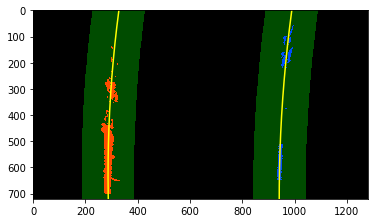

In [19]:
nonzero = warped_img.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100

'''
    NZx & NZy are nonzero x & y
    LF & RF are left_fit & right_fit that is determined above
    left_lane_inds  = (NZx > LF[0]*NZy^2 + LF[1]*NZy + LF[2] - margin) & (NZx > LF[0]*NZy^2 + LF[1]*NZy + LF[2] + margin)
    right_lane_inds = (NZx > RF[0]*NZy^2 + RF[1]*NZy + RF[2] - margin) & (NZx > RF[0]*NZy^2 + RF[1]*NZy + RF[2] - margin)
    Observe only difference is in +/- margin for left and right indices

'''
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & 
                  (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & 
                   (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#Vizualizing the Image - remember this is the 2nd frame and above
out_img = np.dstack((warped_img, warped_img, warped_img))*255
window_img = np.zeros_like(out_img)
#Coloring left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

#This is the search window we are actually considering instead of the whole image
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))

right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

shape of left right (720,) (720,)
Radius of Curvature in metres Left : 571.6491990304202 Right : 542.0745200611998
center offset 1.0099309107535535


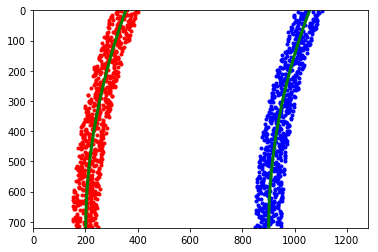

In [8]:
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
print('shape of left right', left_fitx.shape, right_fitx.shape)
# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images


# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
y_eval = np.max(ploty)
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
left_curve_rad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curve_rad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print('Radius of Curvature in metres Left : {} Right : {}'.format(left_curve_rad, right_curve_rad))

#Recheck this
average_curve_rad = (left_curve_rad + right_curve_rad)/2
lane_center = (left_fitx[719] + right_fitx[719])/2
center_offset_pixels = abs(height/2 - lane_center)
center_offset_mtrs = xm_per_pix*center_offset_pixels
print('center offset {}'.format(center_offset_mtrs))

201.745103202 202.755034112 1.00993091075


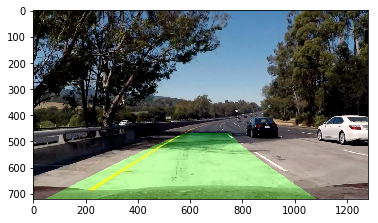

In [14]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped_img).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
leftx_offset_correction = left_fitx + center_offset_mtrs
rightx_offset_correction = right_fitx + center_offset_mtrs
print(left_fitx[680], leftx_offset_correction[680], center_offset_mtrs)
pts_left = np.array([np.transpose(np.vstack([leftx_offset_correction, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([rightx_offset_correction, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
unwarped_img = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 1, unwarped_img, 0.3, 0)
plt.imshow(result)